<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Backward-analysis" data-toc-modified-id="Backward-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Backward analysis</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#Single-unit-change-explanations,-systematic-exploration." data-toc-modified-id="Single-unit-change-explanations,-systematic-exploration.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Single unit change explanations, systematic exploration.</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Training-time" data-toc-modified-id="Training-time-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Training time</a></span></li><li><span><a href="#IPI-(Inter-Pulse-Interval)" data-toc-modified-id="IPI-(Inter-Pulse-Interval)-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>IPI (Inter Pulse Interval)</a></span></li><li><span><a href="#Filters-time-constant-$\tau_z$" data-toc-modified-id="Filters-time-constant-$\tau_z$-1.2.0.3"><span class="toc-item-num">1.2.0.3&nbsp;&nbsp;</span>Filters time constant $\tau_z$</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Backward analysis
This notebook studies what is the tolerance of the network to variability in both:
* Training time
* Inter-Pulse-Interval (IPI).

We first study the effect of varying those for one unit, then we will study the effects of sampling those from distributions:
* Normal
* Uniform

We know analyticall that a backward error will happen when the persistent times in the following triad are arranged in the following way:

Triad: 

1 -- > 2  -- > 3 

$T_{32} <= T_{12} + \tau_a \log \left(2 - e^{- \dfrac{T_{21}}{\tau_a}}\right)$

In terms of the inertia parameters we can write this equation as 

$B_{32} <= 1 - \left(\dfrac{1  - B_{12}}{F}\right)$

Where $F = \Big(2 - (1 - B_{21})(1 - r) \Big)$ 

When finite effects r~ 0 

$F = 1 + B_{21}$

This implies that 
$1 - B_{32} < \dfrac{1 - B_{12}}{1  + B_{21}}$

or 

$ (1 - B_{32})(1  + B_{21}) < 1 - B_{12}$

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

epsilon = 10e-80
vmin = -3.0

## An example

T_21 = 0.203, T_12 = 0.143, T32 = 0.042, limit = 0.253


../network.py:477: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:481: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


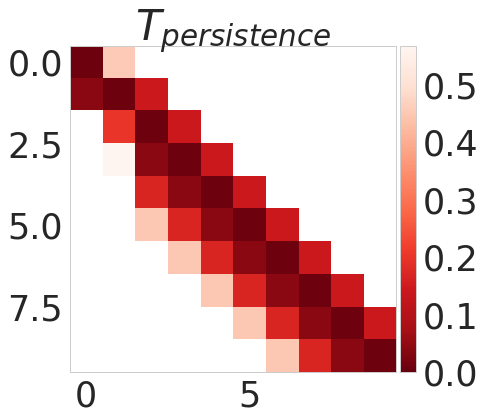

In [82]:
strict_maximum = True

g_a = 5.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
training_times[1] = 10.0
inter_pulse_intervals = [0.0 for i in range(n_patterns)]
inter_pulse_intervals[2] = 0.000
inter_sequence_interval = 0.0
resting_time = 2.0
epochs = 1

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, 
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

T_persistence = manager.calculate_persistence_time_matrix()
plot_persistent_matrix(manager)

T21 = T_persistence[2, 1]
T12 = T_persistence[1, 2]
T32 = T_persistence[3, 2]
limit = T12 + tau_a * np.log(2 - np.exp(-T21 / nn.tau_a))
print(f"T_21 = {T21:3.3f}, T_12 = {T12:3.3f}, T32 = {T32:3.3f}, limit = {limit:3.3f}")


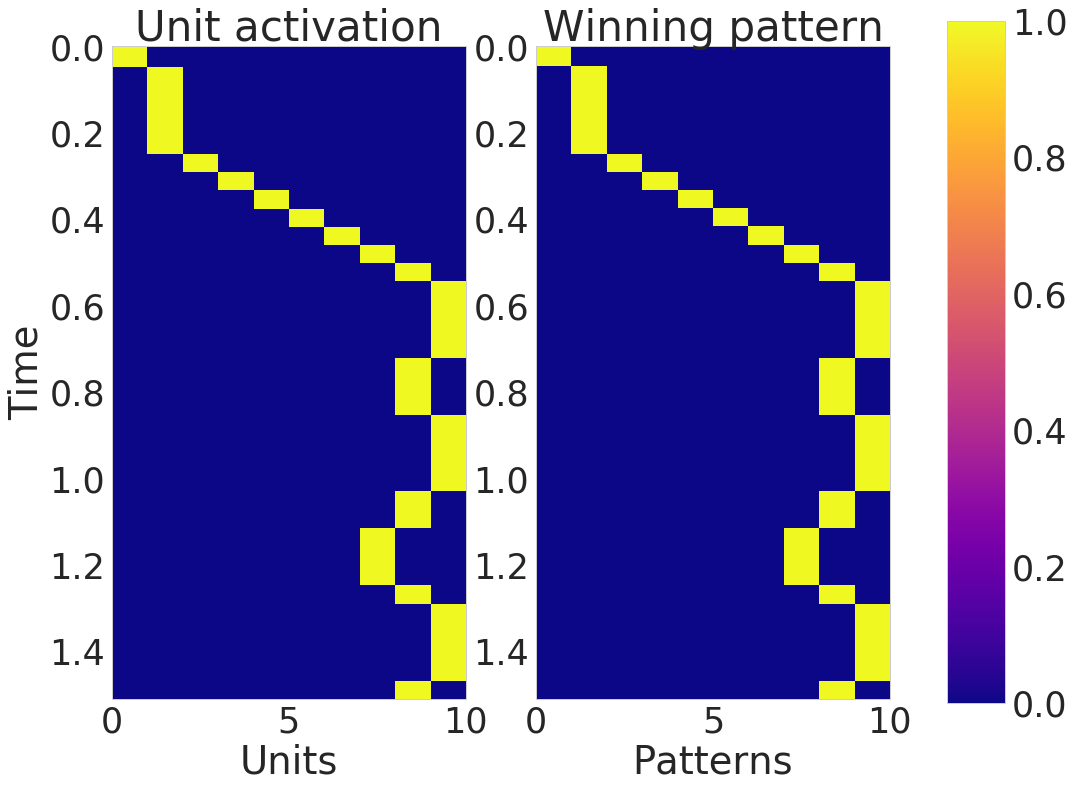

In [83]:
T_recall = 1.5
T_cue = tau_s
I_cue = 0
manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=I_cue, reset=True, empty_history=True)
plot_network_activity_angle(manager)

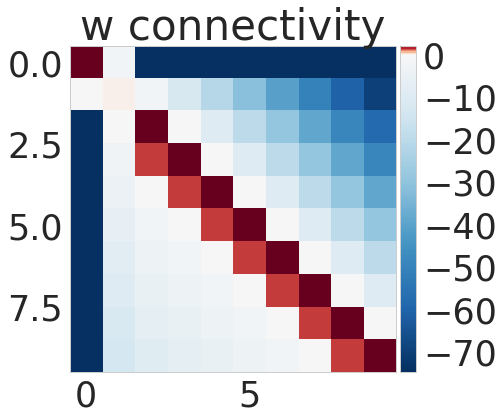

In [84]:
plot_weight_matrix(manager)

## Single unit change explanations, systematic exploration.

In [101]:
values_to_save_string = ['T21', 'T32', 'T12', 'factor', 'B21','B32', 'B12', 'Bfactor']

def update_values_dictionary(manager, values_dictionary, update_index):
    tau_a = manager.nn.tau_a
    r = manager.nn.r
    T_persistence = manager.T
    B = manager.B
    
    T21 = T_persistence[2, 1]
    T32 = T_persistence[3, 2]
    T12 = T_persistence[1, 2]
    factor = T12 + tau_a * np.log(2 - np.exp(-T21 / nn.tau_a))
    
    B21 = B[2, 1]
    B32 = B[3, 2]
    B12 = B[1, 2]
    F = 2 - (1.0 - B21) * (1.0 - r)
    # F = 2 - np.exp(-T21 / tau_a)
    Bfactor = 1 - (1 - B12) / F
    
    # Update the dictionary
    for value in values_dictionary.keys():
        aux = locals()[value]
        values_dictionary[value][update_index] = aux
        
        
def plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None):
    linewidth = 8
    markersize = 28
    colors = sns.color_palette()
    independent_variable = values_dictionary['independent values']
    
    if ax is None:
        figsize = (14, 8)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        
    xlabel = values_dictionary['independent']
    for index, what_to_plot in enumerate(what_to_plot_set):
        dependent_variable = values_dictionary[what_to_plot]    
        ax.plot(independent_variable, dependent_variable, 'o-', ms=markersize, 
                color=colors[index], label=what_to_plot)

    ax.set_xlabel(xlabel)
    if what_to_plot_set[0][0] == 'T':
        ax.set_ylabel(r'$T_{persistence} (ms)$')
    else:
        ax.set_ylabel(r'$B$')

    ax.axhline(0, ls='--', color='gray')
    ax.axvline(0, ls='--', color='gray')
    ax.legend()
    
    return ax

#### Training time 
Here the B21 is pretty much constant, I supect that the delta w and delta beta changes compensate each other. On the other hand the extra-training of the unit manifest itselfs as a tendency to stay in the same unit, this affects both the back-transfer and the forward-transfer in the same way which makes the system process very well representations with variability in the training time.

../network.py:477: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:481: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


CPU times: user 1.34 s, sys: 4 ms, total: 1.34 s
Wall time: 1.34 s


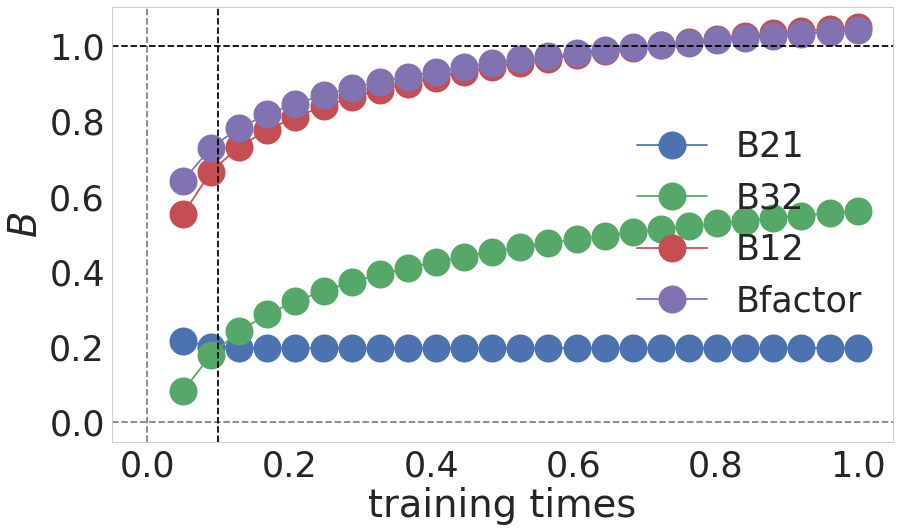

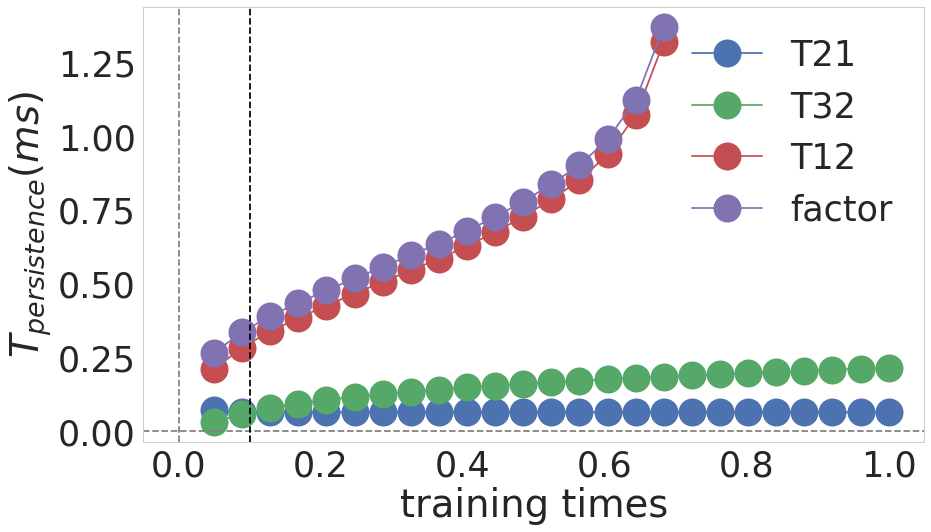

In [102]:
%%time
strict_maximum = True

g_a = 3.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
inter_pulse_intervals = [0.0 for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 2.0
epochs = 1

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

num = 25
training_times_vector = np.linspace(0.050, 1.0, num)
values_dictionary_training_times = {name:np.zeros(num) for name in values_to_save_string}

for index, training_time_diff in enumerate(training_times_vector):
    training_times[2] = training_time_diff
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, 
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)

    T_persistence = manager.calculate_persistence_time_matrix()
    update_values_dictionary(manager, values_dictionary_training_times, index)

values_dictionary_training_times['independent'] = 'training times'
values_dictionary_training_times['independent values'] = training_times_vector

values_dictionary = values_dictionary_training_times
what_to_plot_set = ['B21','B32', 'B12', 'Bfactor']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axvline(0.100, ls='--', color='black')
ax.axhline(1.0, ls='--', color='black')
what_to_plot_set = ['T21', 'T32', 'T12', 'factor']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axvline(0.100, ls='--', color='black');

#### IPI (Inter Pulse Interval)
What we see here? In the first graph the base training time is really high 1.0 s but in the second it is really short 0.100 s. What we see is that the the smaller the training times are, the more resilient the network is to varability on the IPI.

Something that should be noted here is that making the tau_z_pre bigger than tau_z_post (assymetry) should contribute for the system to be able to take a higher IPI vairance.

../network.py:477: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:481: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


CPU times: user 29.5 s, sys: 180 ms, total: 29.7 s
Wall time: 24.7 s


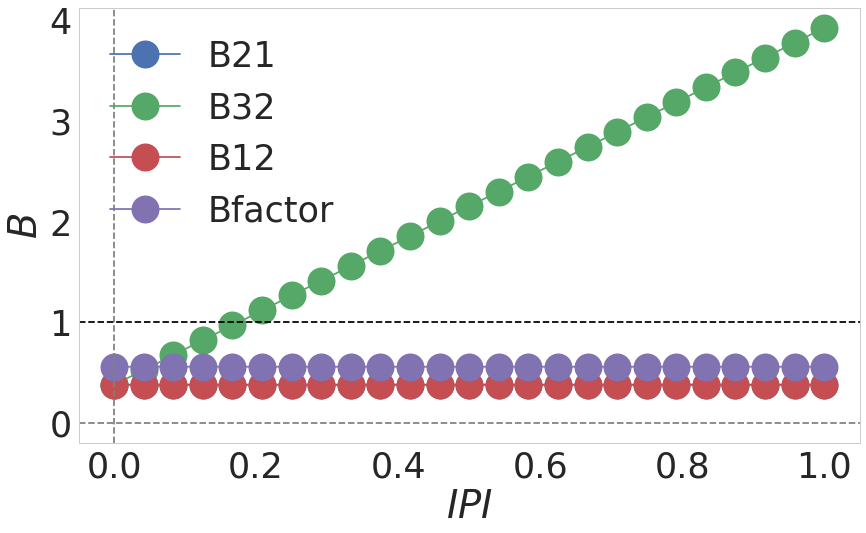

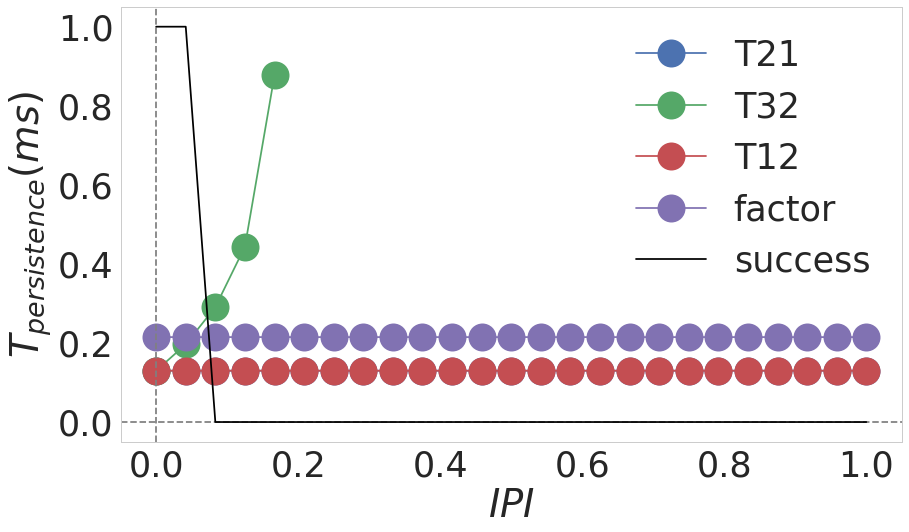

In [103]:
%%time
strict_maximum = True

g_a = 5.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.025

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times_base = 1.00
training_times = [training_times_base for i in range(n_patterns)]
inter_pulse_intervals = [0.0 for i in range(n_patterns)]
resting_time = 2.0
epochs = 1

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

num = 25
IPI_vector = np.linspace(0.000, training_times_base, num)
values_dictionary_IPI = {name:np.zeros(num) for name in values_to_save_string}
success_vector = np.zeros(num)

for index, pulse in enumerate(IPI_vector):
    inter_pulse_intervals[2] = pulse
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, 
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)

    T_persistence = manager.calculate_persistence_time_matrix()
    update_values_dictionary(manager, values_dictionary_IPI, index)
    nr = manager.canonical_network_representation
    T_recall = 5.0
    aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
    success, pattern_sequence, persistent_times, timings = aux
    success_vector[index] = success
    #print('pulse', pulse)
    #print(pattern_sequence)
    #print(success)

values_dictionary_IPI['independent'] = r'$IPI$'
values_dictionary_IPI['independent values'] = IPI_vector

values_dictionary = values_dictionary_IPI

what_to_plot_set = ['B21','B32', 'B12', 'Bfactor']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axhline(1.0, ls='--', color='black')
ax.plot(IPI_vector, success_vector, color='black', label='success')
ax.legend();

what_to_plot_set = ['T21', 'T32', 'T12', 'factor']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.plot(IPI_vector, success_vector, color='black', label='success')
ax.legend();

../network.py:477: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:481: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


CPU times: user 17.7 s, sys: 4 ms, total: 17.7 s
Wall time: 17.7 s


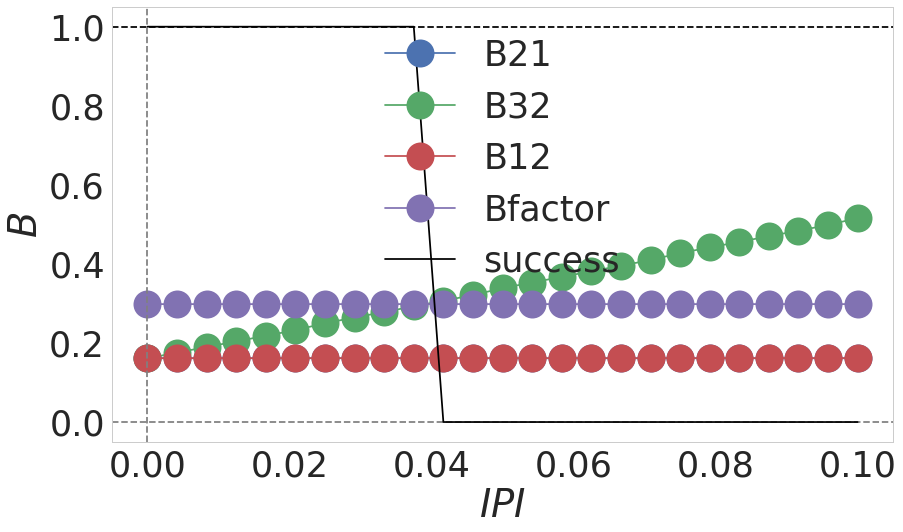

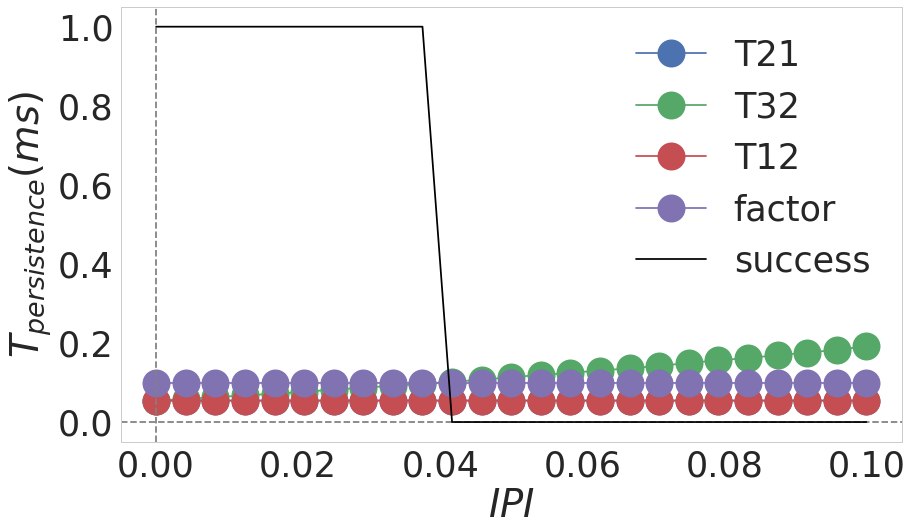

In [104]:
%%time
strict_maximum = True

g_a = 5.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.025

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
inter_pulse_intervals = [0.0 for i in range(n_patterns)]
resting_time = 2.0
epochs = 1

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

num = 25
IPI_vector = np.linspace(0.00, training_times_base, num)
values_dictionary_IPI = {name:np.zeros(num) for name in values_to_save_string}
success_vector = np.zeros(num)

for index, pulse in enumerate(IPI_vector):
    inter_pulse_intervals[2] = pulse
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, 
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)

    T_persistence = manager.calculate_persistence_time_matrix()
    update_values_dictionary(manager, values_dictionary_IPI, index)
    nr = manager.canonical_network_representation
    T_recall = 5.0
    aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
    success, pattern_sequence, persistent_times, timings = aux
    success_vector[index] = success
    #print('pulse', pulse)
    #print(pattern_sequence)
    #print(success)

values_dictionary_IPI['independent'] = r'$IPI$'
values_dictionary_IPI['independent values'] = IPI_vector

values_dictionary = values_dictionary_IPI

what_to_plot_set = ['B21','B32', 'B12', 'Bfactor']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axhline(1.0, ls='--', color='black')
ax.plot(IPI_vector, success_vector, color='black', label='success')
ax.legend();

what_to_plot_set = ['T21', 'T32', 'T12', 'factor']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.plot(IPI_vector, success_vector, color='black', label='success')
ax.legend();

#### Filters time constant $\tau_z$

../network.py:477: RuntimeWarning: invalid value encountered in log
  self.T = self.nn.tau_a * np.log(1 / (1 - self.B))
../network.py:481: RuntimeWarning: invalid value encountered in less
  self.T[self.T < 0] = 0.0


CPU times: user 1.22 s, sys: 16 ms, total: 1.24 s
Wall time: 1.23 s


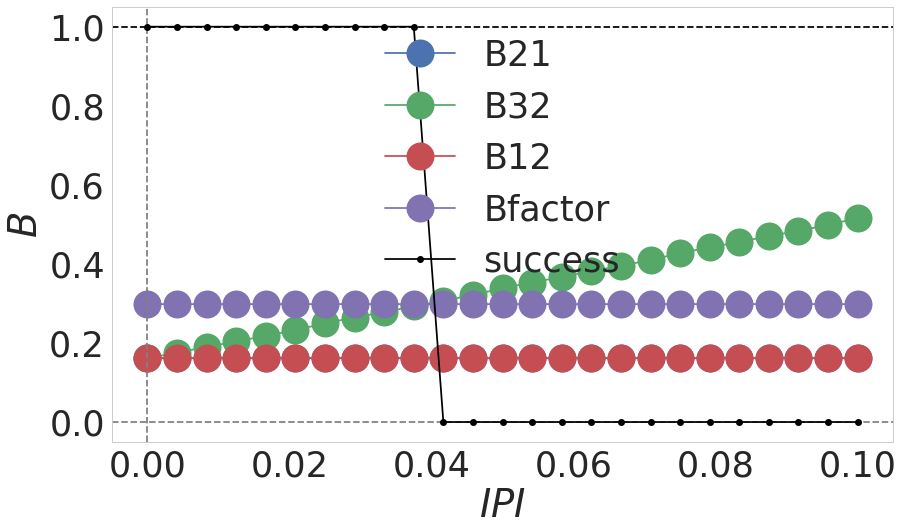

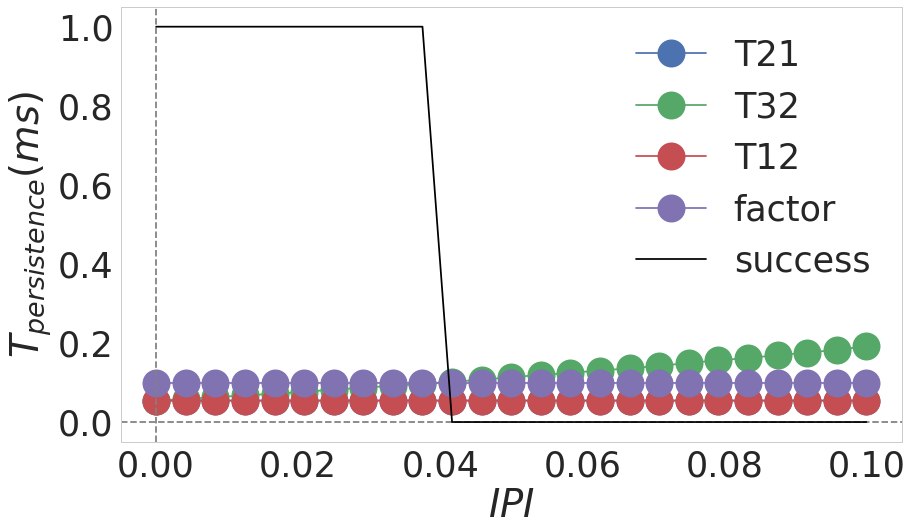

In [105]:
%%time
strict_maximum = True

g_a = 3.0
g_I = 10.0
tau_a = 0.250
G = 1.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.025

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Training protocol
training_times = [0.100 for i in range(n_patterns)]
inter_pulse_intervals = [0.0 for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 2.0
epochs = 1

# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)


num = 25
tau_z_vector = np.linspace(0.005, 0.150, num)
values_dictionary_tau_z = {name:np.zeros(num) for name in values_to_save_string}

for index, tau_z_pre in enumerate(tau_z_vector):
    setattr(nn, 'tau_z_pre', tau_z_pre)
    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, 
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)

    T_persistence = manager.calculate_persistence_time_matrix()
    update_values_dictionary(manager, values_dictionary_tau_z, index)

values_dictionary_tau_z['independent'] = r'$\tau_z$'
values_dictionary_tau_z['independent values'] = tau_z_vector


values_dictionary = values_dictionary_IPI

what_to_plot_set = ['B21','B32', 'B12', 'Bfactor']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.axhline(1.0, ls='--', color='black')
ax.plot(IPI_vector, success_vector, 'o-', color='black', label='success')
ax.legend();

what_to_plot_set = ['T21', 'T32', 'T12', 'factor']
ax = plot_values_from_dictionary(values_dictionary, what_to_plot_set, ax=None)
ax.plot(IPI_vector, success_vector, color='black', label='success')
ax.legend();